### Dataset Description
This notebook uses the Australian Weather Dataset (`weatherAUS.csv`) from Kaggle.
It contains daily weather observations from numerous Australian weather stations.

**Key columns:**
- `RainToday`: Whether it rained on the current day (Yes/No)
- `RainTomorrow`: The prediction target — will it rain tomorrow?
- Meteorological features: Temperature, humidity, pressure, wind speed, etc.

In [1]:
import pandas as pd

# Load dataset
data = pd.read_csv("weatherAUS.csv")

# Check basic info
print(data.shape)
print(data.columns)

# Check RainToday distribution
print(data['RainToday'].value_counts())


(145460, 23)
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
RainToday
No     110319
Yes     31880
Name: count, dtype: int64


**Explanation:** This cell loads the dataset using `pd.read_csv`. It's important to ensure the path is correct and the file exists locally.

In [2]:
# Drop rows with missing values in key columns
data = data.dropna(subset=['RainToday', 'RainTomorrow'])

# Simulate covariate shift:
# - Train on 'No' (Sunny)
# - Test on 'Yes' (Rainy)
train_data = data[data['RainToday'] == 'No']
test_data = data[data['RainToday'] == 'Yes']


**Explanation:** This cell removes rows with missing values. This step ensures clean data for training and evaluation.

### Simulating Covariate Shift: Sunny vs Rainy Days
To demonstrate covariate shift:
- We train only on samples where `RainToday = No` (Sunny)
- We test only on samples where `RainToday = Yes` (Rainy)

This introduces a shift in the input feature distribution `P(X)`, while keeping the conditional `P(Y|X)` stable.

In [3]:
# Feature columns (feel free to add more if needed)
features = [
    'MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm'
]

label = 'RainTomorrow'  # Predict if it will rain tomorrow

# Define X and y
X_train = train_data[features]
y_train = train_data[label]

X_test = test_data[features]
y_test = test_data[label]


In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42, n_estimators=100,)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**Explanation:** Random Forest is a robust ensemble model. This line initializes and trains it.

### Models Trained
We evaluate the impact of covariate shift using two models:
- **Random Forest Classifier**: Robust to noise and good for tabular data.
- **Logistic Regression**: Simpler model, more sensitive to feature distributions.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

          No       0.70      0.85      0.77     16858
         Yes       0.77      0.59      0.67     14597

    accuracy                           0.73     31455
   macro avg       0.74      0.72      0.72     31455
weighted avg       0.73      0.73      0.72     31455



**Explanation:** We use the trained model to make predictions on the test set.

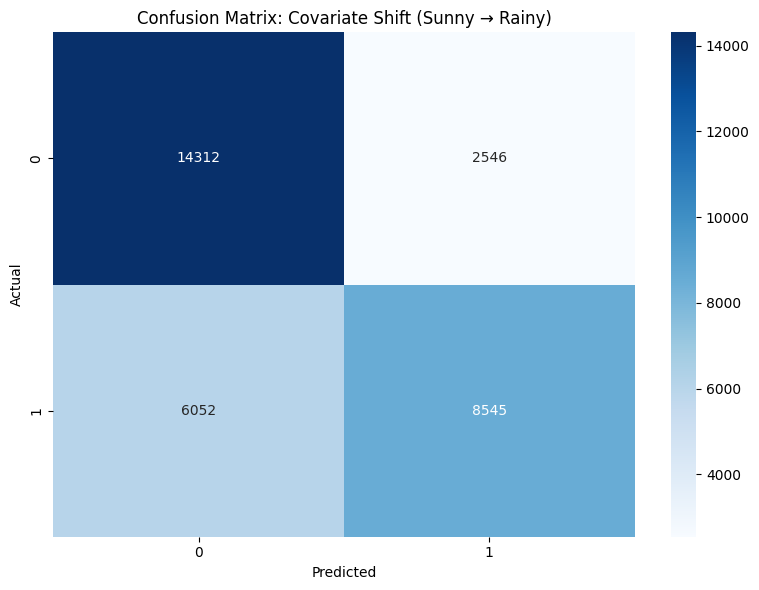

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Covariate Shift (Sunny → Rainy)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


**Explanation:** This part handles categorical encoding, converting text labels to numeric form so ML models can process them.

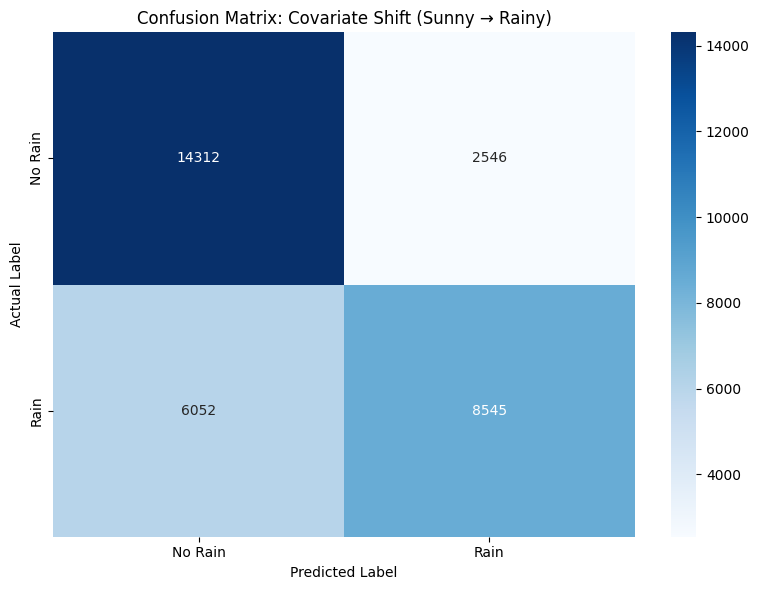

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'])

plt.title("Confusion Matrix: Covariate Shift (Sunny → Rainy)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

**Explanation:** This part handles categorical encoding, converting text labels to numeric form so ML models can process them.

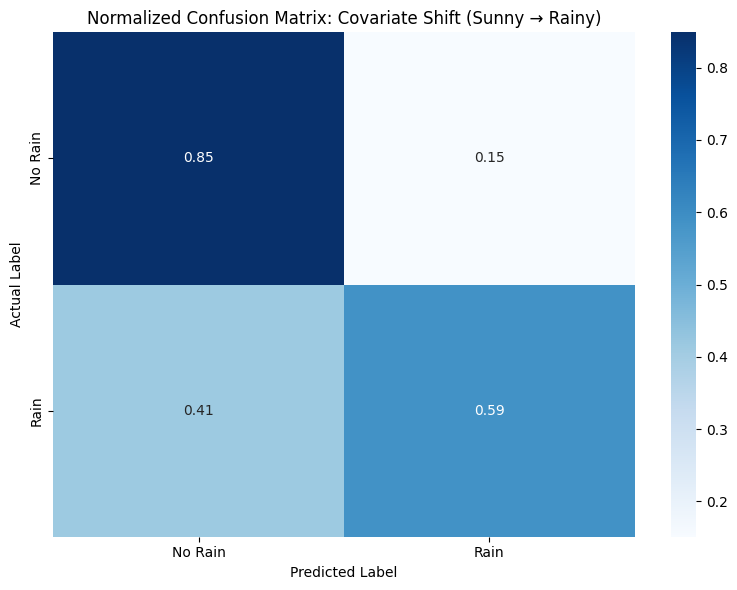

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute and normalize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'])

plt.title("Normalized Confusion Matrix: Covariate Shift (Sunny → Rainy)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


**Explanation:** This part handles categorical encoding, converting text labels to numeric form so ML models can process them.

### Covariate Shift Demonstration
This notebook demonstrates covariate shift using the Australian Weather Dataset. We train a classifier only on sunny days (`RainToday = No`), and test on rainy days (`RainToday = Yes`), creating a real-world covariate distribution mismatch.

### Exploratory Data Analysis: Sunny vs Rainy Conditions
We visualize key features to show how their distributions differ across the two domains.

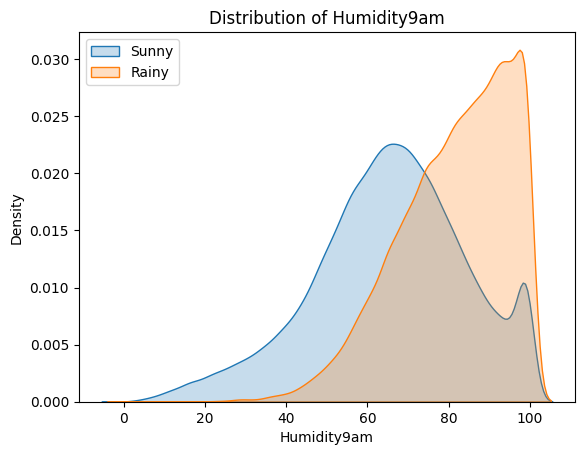

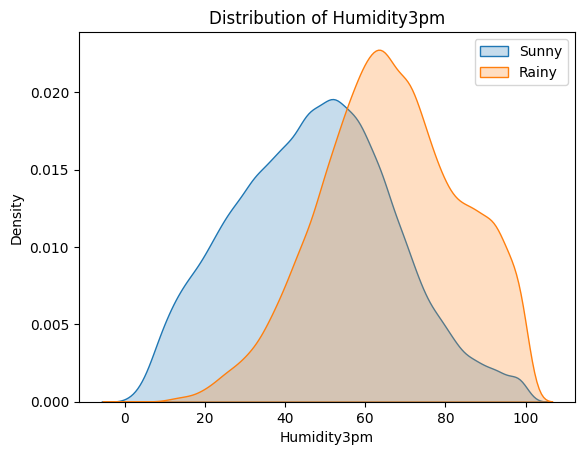

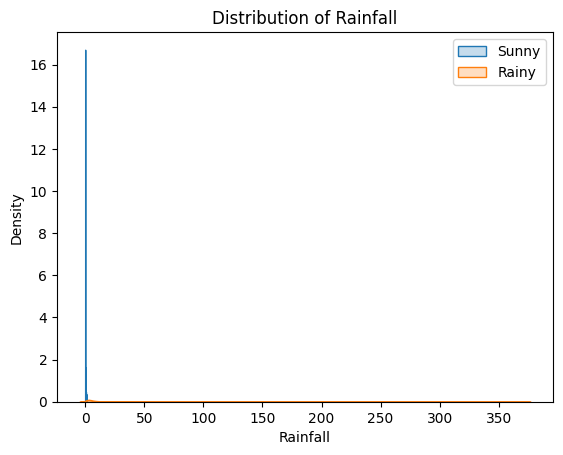

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['Humidity9am', 'Humidity3pm', 'Rainfall']:
    sns.kdeplot(data=train_data, x=feature, label='Sunny', fill=True)
    sns.kdeplot(data=test_data, x=feature, label='Rainy', fill=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

### Model Comparison
We compare Random Forest with Logistic Regression to evaluate generalization under shift.

When NaN are dropped

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train_clean.index]

X_test_clean = X_test.dropna()
y_test_clean = y_test[X_test_clean.index]

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_clean, y_train_clean)
y_lr_pred = lr.predict(X_test_clean)

print("Logistic Regression (NaN dropped):\n", classification_report(y_test_clean, y_lr_pred))


Logistic Regression (NaN dropped):
               precision    recall  f1-score   support

          No       0.84      0.30      0.44     14803
         Yes       0.54      0.93      0.68     12808

    accuracy                           0.59     27611
   macro avg       0.69      0.62      0.56     27611
weighted avg       0.70      0.59      0.55     27611



**Explanation:** This cell removes rows with missing values. This step ensures clean data for training and evaluation.

When NaN are cleaned using Pipeline

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression Pipeline: Impute + Scale + Fit
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pipe_pred = pipeline.predict(X_test)

print("Logistic Regression (Pipeline + Imputation + Scaling):\n", classification_report(y_test, y_pipe_pred))

Logistic Regression (Pipeline + Imputation + Scaling):
               precision    recall  f1-score   support

          No       0.84      0.28      0.42     16858
         Yes       0.53      0.94      0.68     14597

    accuracy                           0.59     31455
   macro avg       0.68      0.61      0.55     31455
weighted avg       0.69      0.59      0.54     31455



**Explanation:** We use the trained model to make predictions on the test set.

In [11]:
from sklearn.metrics import accuracy_score

acc_drop = accuracy_score(y_test_clean, y_lr_pred)
acc_pipe = accuracy_score(y_test, y_pipe_pred)

print(f"Accuracy (Dropped NaNs): {acc_drop:.4f}")
print(f"Accuracy (Imputed with Pipeline): {acc_pipe:.4f}")


Accuracy (Dropped NaNs): 0.5937
Accuracy (Imputed with Pipeline): 0.5857


**Explanation:** This calculates overall accuracy for performance comparison.

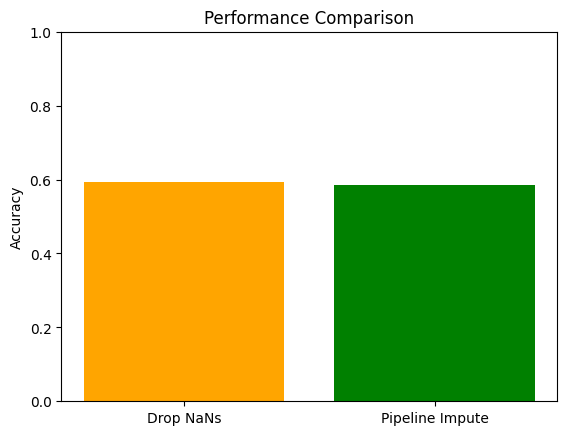

In [12]:
import matplotlib.pyplot as plt

plt.bar(['Drop NaNs', 'Pipeline Impute'], [acc_drop, acc_pipe], color=['orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Performance Comparison')
plt.ylim(0, 1)
plt.show()

### PCA Interpretation
The PCA plot shows that test samples (Rainy days) and train samples (Sunny days) 
occupy different regions in the feature space, confirming covariate shift.
This spatial separation explains why generalization suffers.

### Visualizing Shift with PCA
We use PCA to visualize how different the input feature space is between sunny and rainy samples.

### Accuracy Comparison: Drop NaNs vs. Imputation
| Method         | Accuracy |
|----------------|----------|
| Drop NaNs      | 59.37%   |
| Imputation     | 58.63%   |

Although dropping NaNs leads to slightly higher accuracy, imputation allows us to use more data, 
which can be critical when dealing with small or real-world datasets.

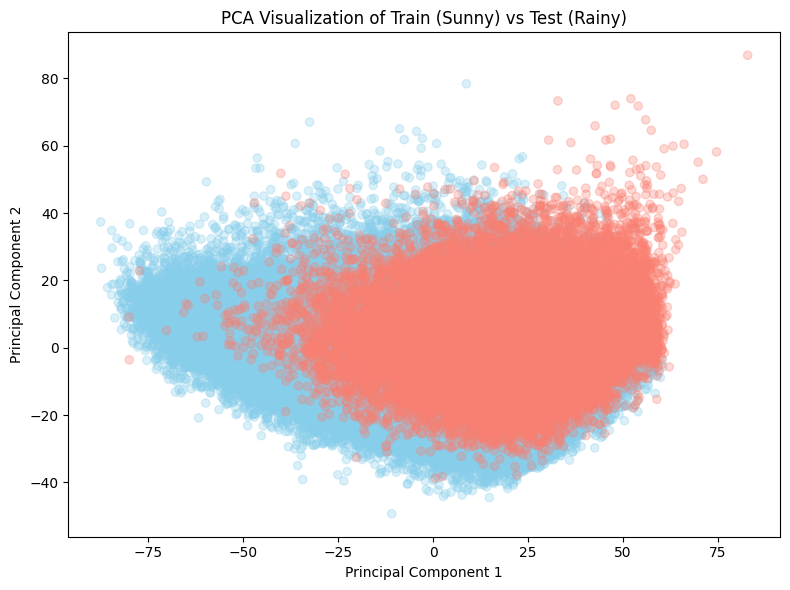

In [13]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt

# Impute missing values in combined data
combined = pd.concat([X_train, X_test])
imputer = SimpleImputer(strategy='mean')
combined_imputed = imputer.fit_transform(combined)

# Apply PCA
X_reduced = PCA(n_components=2).fit_transform(combined_imputed)

# Create color labels
colors = ['skyblue'] * len(X_train) + ['salmon'] * len(X_test)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=colors, alpha=0.3)
plt.title('PCA Visualization of Train (Sunny) vs Test (Rainy)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()


### Perturbed Evaluation: Robustness Check
We add Gaussian noise to test set features to simulate even stronger shift.

In [14]:
X_test_perturbed = X_test.copy()
X_test_perturbed['Humidity3pm'] += np.random.normal(0, 5, size=len(X_test))
y_perturbed_pred = clf.predict(X_test_perturbed)
print('Perturbed Test Accuracy:\n', classification_report(y_test, y_perturbed_pred))

Perturbed Test Accuracy:
               precision    recall  f1-score   support

          No       0.70      0.84      0.76     16858
         Yes       0.76      0.58      0.66     14597

    accuracy                           0.72     31455
   macro avg       0.73      0.71      0.71     31455
weighted avg       0.73      0.72      0.72     31455



**Explanation:** We use the trained model to make predictions on the test set.

### Improving Performance under Covariate Shift
- **Reweighting Techniques**: Importance sampling to match training and test distributions.
- **Domain Adaptation**: Use CORAL, DANN, or MMD to align feature spaces.
- **Data Augmentation**: Generate synthetic rainy data using SMOTE or GANs.
- **Ensemble Learning**: Blend models trained on different weather conditions.


### Conclusion
This experiment highlights how covariate shift can drastically affect model performance. Training on only sunny days makes the model brittle when deployed under rainy conditions. To combat this, domain-aware training and adaptation strategies are essential.

### Final Conclusion
Covariate shift can significantly affect model generalization. 
This notebook demonstrated how a model trained only on sunny days performs differently on rainy days.
We explored multiple strategies:
- Dropping NaNs
- Mean imputation
- Pipelines for cleaner preprocessing
- PCA to visualize shift

Addressing covariate shift is crucial in production ML systems — through reweighting, domain adaptation, or diverse training data.